## Result Analysis I

In [1]:
from glob import glob
import json
import os
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
report_files = glob('reports/*.json')
print(f"Number of report files: {len(report_files)}")

Number of report files: 703


In [3]:
protein_to_uniprot = json.load(open('protein_to_uniprot.json', 'r'))
uniprot_to_protein = json.load(open('uniprot_to_protein_name.json', 'r'))

In [4]:
model_names= []

In [5]:
metrics = ['accuracy', 'f1_score', 'cohen_kappa', 'mcc']
models = ['xgb', 'rf', 'svc', 'mlp']
data_metrics = ['train_count', 'test_count', 'actives_count', 'decoys_count']
report = dict()

for _file in report_files:
    # Strip the model name
    _dir, _model_name = os.path.split(_file)
    model_name = os.path.splitext(_model_name)[0][:6]
    
    # Load the dictionary
    _dict = json.load(open(_file, 'r'))
    #model_name = _dict['xgb']['uniprot_id']
    model_names.append(model_name)
    
    # Extract the metrics
    _report = [round(_dict[model][metric], 4) for model in models for metric in metrics]
    
    # Find the best model
    # Use cohen kappa, if not available then use f1 score
    scores = np.array([_dict[model]['cohen_kappa'] for model in models])
    best_metric = 'cohen_kappa'
    if 0 in scores:
        scores = np.array([_dict[model]['f1_score'] for model in models])
        best_metric = 'f1_score'
        
    best_model = models[np.argmax(scores)]
    best_score = round(np.max(scores), 4)
    _data_info = [_dict['xgb']['data_info'][c] for c in data_metrics]
    report[model_name] = _report + _data_info + [best_model, best_metric, best_score]
    #break

report_df = pd.DataFrame.from_dict(report, orient='index')
report_df.columns = [f"{model}_{metric}" for model in models for metric in metrics] + data_metrics + ['best_model', 'best_metric', 'best_score']

In [6]:
report_df.head(5)

,xgb_accuracy,xgb_f1_score,xgb_cohen_kappa,xgb_mcc,rf_accuracy,rf_f1_score,rf_cohen_kappa,rf_mcc,svc_accuracy,svc_f1_score,...,mlp_f1_score,mlp_cohen_kappa,mlp_mcc,train_count,test_count,actives_count,decoys_count,best_model,best_metric,best_score
P24530,1.0000,1.0000,1.0000,1.0000,0.9916,0.9916,0.9811,0.9812,0.9916,0.9916,...,0.9916,0.9813,0.9815,475,119,198,396,xgb,cohen_kappa,1.0000
Q9UGN5,0.9600,0.9570,0.7289,0.7411,0.9733,0.9713,0.8193,0.8330,1.0000,1.0000,...,0.9713,0.8193,0.8330,598,150,68,680,svc,cohen_kappa,1.0000
P49798,0.9884,0.9880,0.9270,0.9295,1.0000,1.0000,1.0000,1.0000,0.9884,0.9887,...,0.9880,0.9270,0.9295,343,86,39,390,rf,cohen_kappa,1.0000
O14684,0.9914,0.9912,0.9453,0.9467,0.9871,0.9866,0.9161,0.9193,0.9756,0.9761,...,0.9891,0.9329,0.9333,5561,1391,632,6320,xgb,cohen_kappa,0.9453
Q9BY41,0.9724,0.9723,0.9377,0.9377,0.9807,0.9806,0.9561,0.9566,0.9420,0.9418,...,0.9530,0.8943,0.8943,1447,362,603,1206,rf,cohen_kappa,0.9561


In [7]:
report_df.to_csv('Report.csv')

best_model
mlp    114
rf     237
svc    156
xgb    196
dtype: int64


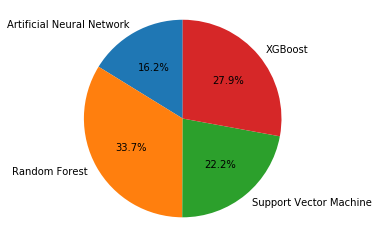

In [8]:
count = report_df.groupby('best_model').size()
print(count)
fig1, ax1 = plt.subplots()
ax1.pie(count, 
        autopct = '%1.1f%%',
        startangle = 90,
        labels = ['Artificial Neural Network', 'Random Forest', 'Support Vector Machine', 'XGBoost'])
ax1.axis('equal')
plt.savefig('plots/model_pie', dpi=300)
plt.show()

In [9]:
report_df.groupby('best_metric').size()

best_metric
cohen_kappa    703
dtype: int64

### Results Analysis II: Count number of models developed for each protein type

In [10]:
# Load Report file
rdf = pd.read_csv('Report.csv', index_col = 0)
rdf.head(3)

,xgb_accuracy,xgb_f1_score,xgb_cohen_kappa,xgb_mcc,rf_accuracy,rf_f1_score,rf_cohen_kappa,rf_mcc,svc_accuracy,svc_f1_score,...,mlp_f1_score,mlp_cohen_kappa,mlp_mcc,train_count,test_count,actives_count,decoys_count,best_model,best_metric,best_score
P24530,1.0000,1.000,1.0000,1.0000,0.9916,0.9916,0.9811,0.9812,0.9916,0.9916,...,0.9916,0.9813,0.9815,475,119,198,396,xgb,cohen_kappa,1.0
Q9UGN5,0.9600,0.957,0.7289,0.7411,0.9733,0.9713,0.8193,0.8330,1.0000,1.0000,...,0.9713,0.8193,0.8330,598,150,68,680,svc,cohen_kappa,1.0
P49798,0.9884,0.988,0.9270,0.9295,1.0000,1.0000,1.0000,1.0000,0.9884,0.9887,...,0.9880,0.9270,0.9295,343,86,39,390,rf,cohen_kappa,1.0


In [11]:
# Select columns with information about best models
rdf = rdf[['best_model', 'best_metric', 'best_score']]
rdf.head(3)

,best_model,best_metric,best_score
P24530,xgb,cohen_kappa,1.0
Q9UGN5,svc,cohen_kappa,1.0
P49798,rf,cohen_kappa,1.0


In [13]:
# Load json file containing the uniprot ids and their corresponding family name
with open('uniprot_to_family_name.json') as json_file:
    data = json.loads(json_file.read())


In [14]:
# Create list of family name of each uniprot
family = []
for i in range(len(rdf)):
    uniprot = rdf.index[i]
    for key in data.keys():
        if uniprot in data[key]:
            family.append(key)
    else:
        continue

In [15]:
# Insert the family info to existing dataframe.
rdf.insert(0,'protein_family',family)
rdf.head(3)

,protein_family,best_model,best_metric,best_score
P24530,GPCR,xgb,cohen_kappa,1.0
Q9UGN5,Enzyme,svc,cohen_kappa,1.0
P49798,Other,rf,cohen_kappa,1.0


In [16]:
# write csv file containing uniprot id, protein family, best model name, best metric and best score
rdf.to_csv('models_with_family_name.csv', index = False)

In [17]:
# Group by best models
ndf = pd.DataFrame({'best_model':list(rdf['best_model']), 'protein_family':list(rdf['protein_family'])})#, 'uniprot':list(r3df['uniprot']), 'best_metric':list(r3df['best_metric']), 'best_score':list(r3df['best_score'])})

In [18]:
# make list of grouped protein families
group_df =ndf.groupby('best_model')['protein_family'].apply(list)
group_df

best_model
mlp    [GPCR, Enzyme, IC, GPCR, Kinase, Enzyme, Enzym...
rf     [Other, Epigenetic, Kinase, Epigenetic, Kinase...
svc    [Enzyme, Other, Kinase, Transporter, Kinase, K...
xgb    [GPCR, Enzyme, Kinase, GPCR, Enzyme, Enzyme, E...
Name: protein_family, dtype: object

In [19]:
group_df = ndf.groupby('best_model')['protein_family'].apply(list).reset_index(name='protein_family')

In [20]:
# for i in range(len(group_df)):
#     print(set(group_df['protein_family'][i]))

In [21]:
# Count models of each model type and protein type
models= {}
protein_fam = ['Kinase', 'Transporter', 'Epigenetic', 'IC', 'Other', 'NR', 'Enzyme', 'GPCR', 'TF; Epigenetic', 'TF']
for f in range(len(group_df)):
    name = group_df['best_model'][f]
    models_freq  = {}
    for p in protein_fam:
        family_list = group_df['protein_family'][f]
        count = family_list.count(p)
        models_freq[p] = count
    models[name] = models_freq
models

{'mlp': {'Enzyme': 44,
  'Epigenetic': 5,
  'GPCR': 25,
  'IC': 6,
  'Kinase': 26,
  'NR': 2,
  'Other': 5,
  'TF': 0,
  'TF; Epigenetic': 1,
  'Transporter': 0},
 'rf': {'Enzyme': 81,
  'Epigenetic': 13,
  'GPCR': 42,
  'IC': 17,
  'Kinase': 40,
  'NR': 7,
  'Other': 31,
  'TF': 1,
  'TF; Epigenetic': 0,
  'Transporter': 5},
 'svc': {'Enzyme': 55,
  'Epigenetic': 6,
  'GPCR': 21,
  'IC': 4,
  'Kinase': 38,
  'NR': 6,
  'Other': 19,
  'TF': 2,
  'TF; Epigenetic': 1,
  'Transporter': 4},
 'xgb': {'Enzyme': 79,
  'Epigenetic': 8,
  'GPCR': 37,
  'IC': 13,
  'Kinase': 29,
  'NR': 5,
  'Other': 18,
  'TF': 1,
  'TF; Epigenetic': 0,
  'Transporter': 6}}

In [22]:
# Save ML models and protein types info.
with open('models_family_frequency.json', 'w') as json_file:
  json.dump(models, json_file)
# Save in csv file as well
pd.read_json('models_family_frequency.json').to_csv('models_family_frequency.csv')